# Synthetic Training Data Generation via Inpainting 
### Matt Franchi, December 2022 


This notebook demonstrates a pipeline for generating synthetic training data using Stable Diffusion 2 (SD2) inpainting technology. All project resources are provided as-is. 

### Preqrequisites
*ONLY RUN THIS ONCE* 

In [ ]:
%%sh
pip install -q --upgrade pip
pip install -q --upgrade diffusers transformers scipy ftfy huggingface_hub roboflow

The SD2 model from HuggingFace requires a user access token that can be generated for free by creating an account at [huggingface.co](https://huggingface.co). 

In [2]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/mwf62/.huggingface/token
Login successful


These constants are relatively self-explanatory. 
TRAIN_LABELS_PATH defines the location on-disk where train labels are stored. 
TRAIN_IMAGES_PATH defines the location on-disk where train images are stored. 
CACHE_DIR defines the location on-disk where SD2 model will be downloaded to. Keep in mind that the model is a several-gigabyte download. 
OUTPUT_DIR defines the location on-disk where generated images are stored. 

In [3]:
TRAIN_LABELS_PATH = "./AI-Inpainting-Test/labels"
TRAIN_IMAGES_PATH = "./AI-Inpainting-Test/images"
CACHE_DIR = "/share/pierson/nexar_data/cache"
OUTPUT_DIR = "./AI-Inpainting-Test/synthetic"

### Reading in Project Files

Read training labels and images from disk. Each image should have an identical basename (sans extension) to its corresponding label. 

In [5]:
import glob, os
 
train_labels = glob.glob(f"{TRAIN_LABELS_PATH}/*.txt")
train_images = [os.path.splitext(os.path.basename(x))[0]+".jpg" for x in train_labels]
train_images = [os.path.join(f"{TRAIN_IMAGES_PATH}",x) for x in train_images]

# Sanity check
assert len(train_labels) == len(train_images)       

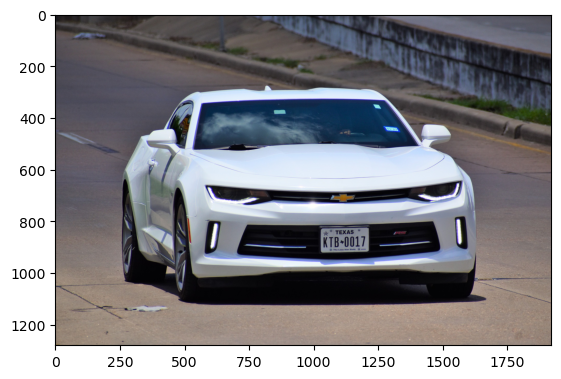

In [6]:
import skimage.io
import skimage.draw
import numpy as np
import matplotlib.pyplot as plt

# Load and display the original image
image = skimage.io.imread(fname=train_images[0])

fig, ax = plt.subplots()
plt.imshow(image)

### Generating Image Mask

An image mask for the training image is generated from the corresponding label file. My code expects labels to be in YOLO format. It is possible (and easy) to change this code to parse using another format (COCO, etc.) 

949 692 1489 914


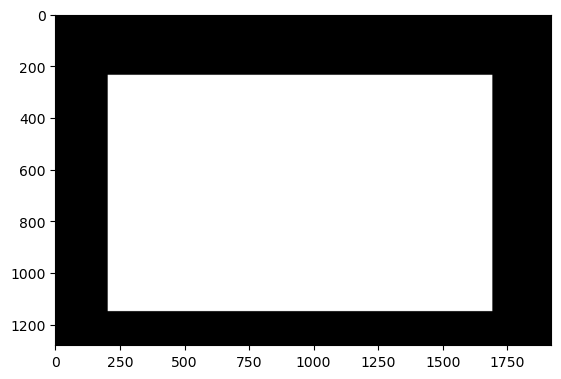

In [7]:
from PIL import Image 

img_height, img_width, _ = image.shape 
# padding around the original bounding box, expressed as a % of overall width/height 
PADDING = 0.03

with open(train_labels[0],'r') as data_file:
    for line in data_file:
        # annotations are in x_center, y_center, width, height 
        g, x, y, w, h = line.split()
        x = int(float(x) * img_width)
        y = int(float(y) * img_height)
        w = int((float(w) + PADDING) * img_width)
        h = int((float(h) + PADDING) * img_height)
        print(x, y, w, h)
        break

mask_bg = Image.new("RGBA", (img_width, img_height), "#000000")
mask = Image.new("RGBA", (w, h), "#ffffff")
mask_bg.paste(mask, (int(x-w/2),int(y-h/2)), mask=mask)
mask = mask_bg
plt.imshow(mask)

### Resizing for SD2

The lower the resolution, the quicker processing is. As such, I opted to scale my test image and mask to 512x512 resolution. You could play around with higher resolutions, try them out! 

In [8]:
image = Image.fromarray(image)

print(image.size)
print(mask.size)

image = image.resize((512,512))
mask = mask.resize((512,512))

print(image.size)
print(mask.size)

(1920, 1280)
(1920, 1280)
(512, 512)
(512, 512)


### SD2 Image Generation

This snippet downloads the stable-diffusion-2-inpainting model from HuggingFace. 

In [9]:
import torch
from diffusers import StableDiffusionInpaintPipeline

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting", cache_dir=CACHE_DIR
)
pipe = pipe.to("cuda")



Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

This snippet does the actual image generation. Thanks to the HuggingFace diffusers library, this is a very short snippet of code. 

  0%|          | 0/50 [00:00<?, ?it/s]

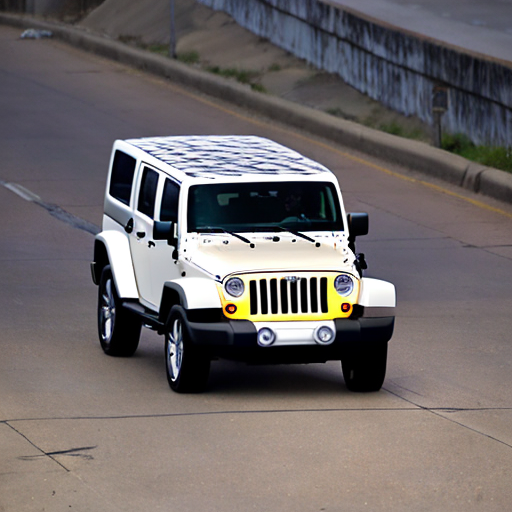

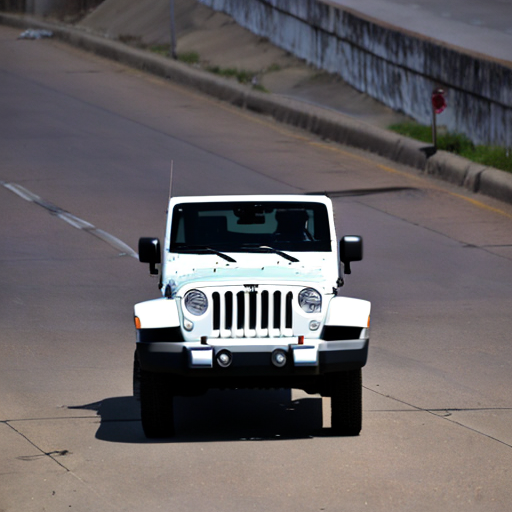

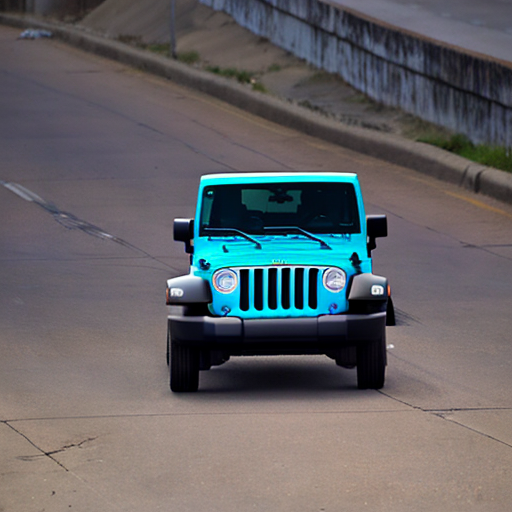

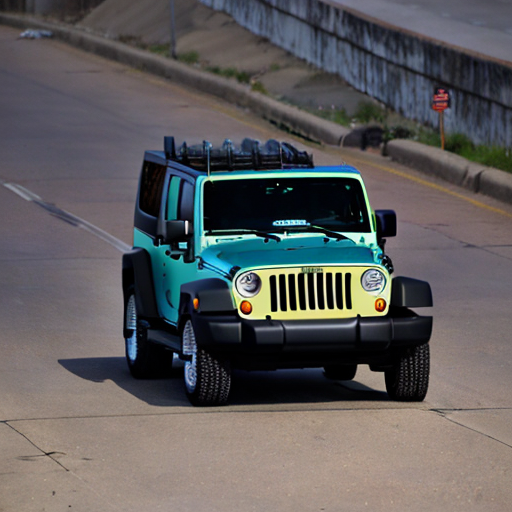

In [10]:
from IPython.display import Image, display
prompt = "high-resolution jeep wrangler driving on the road"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
images = pipe(prompt=prompt, image=image, mask_image=mask, height=image.height, width=image.width, num_inference_steps=50, num_images_per_prompt=4, guidance_scale=8)
for i in range(len(images.images)): 
    images.images[i].save(f"image_{i}.png")
    display(Image(filename=f"image_{i}.png"))
